# Introduction to R Programming: Loops, Conditionals, & Functions

Matthew D. Turner, PhD  
Georgia State University

Some rights reserved: [cc by-nc-sa](https://creativecommons.org/licenses/by-nc-sa/4.0/) See bottom of document for details.
***
# Bootstrapping
A very general statistical technique is the [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29) invented by the statistician [Brad Efron](https://en.wikipedia.org/wiki/Bradley_Efron) in the [late 1970's](https://projecteuclid.org/download/pdf_1/euclid.aos/1176344552). The central idea of bootstrapping is to **resample** data using some form of sampling _with replacement_. In essence, it replaces parametric assumptions with computing power. The method is related (in an evolutionary sense) to other methods such as [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) and the [jacknife](https://en.wikipedia.org/wiki/Jackknife_resampling) (see also [this](http://www.math.ntu.edu.tw/~hchen/teaching/LargeSample/references/Miller74jackknife.pdf)), the latter being developed by [Quenouille](https://en.wikipedia.org/wiki/Maurice_Quenouille); and all of these are very useful in machine learning and regression contexts. The bootstrap was originally introduced to estimate **bias** in statistical estimators. A good summary of uses for the bootstrap is given [here](https://projecteuclid.org/download/pdf_1/euclid.ss/1177013815).

## What is the Bootstrap?
The bootstrap uses the sample as a [plug-in estimate](https://www.researchgate.net/publication/236647074_Using_Bootstrap_Estimation_and_the_Plug-in_Principle_for_Clinical_Psychology_Data) of the distribution (population) from which the data was drawn. Traditional statistics assumes a parametric form (usually the normal or Gaussian) for this population. The assumption is that the features of the distribution are reflected in the same features of the sample. Wikipedia describes it:

> More formally, the bootstrap works by treating inference of the true probability distribution J, given the original data, as being analogous to inference of the empirical distribution Ĵ, given the resampled data. The accuracy of inferences regarding Ĵ using the resampled data can be assessed because we know Ĵ. If Ĵ is a reasonable approximation to J, then the quality of inference on J can in turn be inferred. [From Wikipedia](https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29#Approach).

So, in essence, we treat **resamples** (with replacement) from the sample as being analogous to a collection of **samples** from the original population. (Resamples are to the sample, what samples are to the population.) Despite the fact that this sounds somewhat silly (it really does seem like a magic trick!) it tends to work in a lot of applied cases. Also, there has been a thorough theoretical basis developed for the method.

**Important Note**: Although the simplest form of bootstrapping discussed here does work for some problems, it is **not** to be taken as a general technique to be used without significant study on your part. In general, this simplest version of the method is **not** to be used directly for real-world data problems, but should instead be replaced by several better, somewhat more complicated, methods such as the **bias-corrected and accelerated bootstrap**, the **ABC bootstrap**, and the **bootstrap-T**. All of these are covered in [DiCiccio and Efron (1996)](https://projecteuclid.org/download/pdf_1/euclid.ss/1032280214), and [Carpenter and Bithell (2000)](https://www.tau.ac.il/~saharon/Boot/10.1.1.133.8405.pdf) provides a general survey. For the average user, Carpenter and Bithell may be the best available paper to start your reading. For a less technical introduction, see [Wright, London, and Field (2011)](https://www.researchgate.net/publication/236647074_Using_Bootstrap_Estimation_and_the_Plug-in_Principle_for_Clinical_Psychology_Data), however this paper does not go into detail on the more advanced methods.

## Why Discuss This Here?
Implementing the bootstrap in R requires using either functions or loops, or both, so it is a good topic to show off using these structures.

### Prerequisites
To fully follow the bootstrap details in this section, you will need to know a little bit about statistical inference, normal theory, confidence intervals, and probability. To follow just the parts dealing with using the structures from this workshop, you can ignore some of the details and you should be fine.
***
## Bootstrap Example (Means)
In this notebook we will analyze a very simple case using the **percentile bootstrap**. This is a method for estimating upper and lower bounds for the confidence interval around the mean. You hopefully remember confidence intervals from introductory statistics, particularly under the assumption of a normal distribution.

When the data is symmetric and there is a large sample this method works well, however for most real-world problems it should be replaced by the BC<sub>a</sub> (bias-corrected and accelerated) bootstrap. 

First, let's generate a random set of data to use for analysis. We use `rnorm` which makes up normally distributed random numbers. Here we make up 100 random numbers, from a distribution with a mean 50 and standard deviation 10.

In the following cell we also use the `set.seed` function in R which "reboots" the random number generator and sets it to a specific starting state. This makes sure that when you run this file you get the same random numbers each time.

In [199]:
set.seed(1000)
x <- rnorm(100, mean = 50, sd = 10)
x

[1] 45.54222 37.94143 50.41126 56.39388 42.13446 46.14511 45.24132 57.19751
  [9] 49.81494 36.26882 40.17572 44.45511 51.21381 48.79128 36.63959 51.70057
 [17] 51.55079 50.24932 29.53415 52.13154 76.70072 37.72984 58.34247 55.32572
 [25] 43.53175 56.03161 32.16156 53.34942 55.60976 62.20936 47.88546 56.99430
 [33] 42.93563 45.34849 32.33801 51.89289 46.33819 60.57601 42.58379 36.51641
 [41] 44.82694 64.11736 51.85465 49.56309 47.84087 64.63775 52.29667 51.07624
 [49] 36.21897 40.31817 52.51711 39.05306 53.97643 40.03698 51.00578 59.53680
 [57] 32.09677 53.11701 75.53988 41.39162 55.43928 46.07662 62.35442 61.96086
 [65] 45.04253 47.05659 44.26503 66.19209 40.43072 50.41237 35.01690 56.60959
 [73] 52.85458 63.88866 48.40656 45.39081 51.68438 63.95493 57.28426 53.35090
 [81] 61.69276 52.47967 46.41851 63.83493 54.12069 48.76992 49.33771 26.77509
 [89] 39.54343 70.57875 69.71532 30.79005 54.62126 48.39276 48.95788 54.67839
 [97] 54.43921 58.28553 46.12950 70.18938

According to theory the 95% confidence interval (CI) is given by the formula: $$\bar{x} \pm t_{n - 1} \cdot \frac{s_x}{\sqrt{n}}$$ where $\bar{x}$ is the mean of the $x$'s, $t$ is the (95%) "critical value" from the $t$-distribution, $n$ is the sample size, and $s_x$ is the standard deviation of the data.

This value is returned as part of the output of the `t.test` function in R. If you have not used the `t.test` function before, consult the help for this, then run `t.test` on `x`.

In [ ]:
# Apply the t.test function to x



In [200]:
t.test(x)


	One Sample t-test

data:  x
t = 49.835, df = 99, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 48.16649 52.16109
sample estimates:
mean of x 
 50.16379 


What is the 95% CI? Find it in the output you just got.

In [201]:
# Here is a method for picking out just the CI values from the
# t.test output:

t.test(x)$conf.int

[1] 48.16649 52.16109
attr(,"conf.level")
[1] 0.95

The CI above is the normal-theory CI, it assumes that the data is normal, and deduces the limits of the interval from the theoretical properties of the normal. However there is another way to get an approximation to this. We can:
1. Draw a resample from the data.
1. Compute the statistic of interest (here the `mean`).
1. Repeat this many times, collecting the means. (This collection will be the bootstrap estimate of the distribution of the mean.)
1. Determine the percentile limits of this distribution.

We will do this step-by-step below.

### 1. How do we get a resample?

R has functions for drawing a sample from a list of numbers. The main function is:

```R
sample(x, size, replace = FALSE)
```

This function takes `x` as input, draws a sample of a size you determine, and can be done both with and without replacement. For bootstrapping the sampling is **always** done with replacement, so we have to set `replace = TRUE` in all of our work.

We will always take a sample equal in size to the size of our original data.

In [202]:
# The following draws a sample of size 100 from the previous random numbers x with replacement

boot_sample <- sample(x, size = 100, replace = TRUE)
boot_sample

[1] 49.81494 45.34849 32.09677 40.31817 64.63775 32.33801 61.69276 59.53680
  [9] 59.53680 35.01690 53.11701 61.96086 47.05659 59.53680 37.94143 49.56309
 [17] 54.12069 48.79128 39.54343 52.47967 63.95493 60.57601 42.58379 51.89289
 [25] 64.11736 41.39162 47.84087 54.12069 54.43921 46.07662 56.99430 37.72984
 [33] 46.07662 55.43928 45.24132 58.34247 48.95788 60.57601 41.39162 46.41851
 [41] 56.60959 48.95788 60.57601 45.54222 66.19209 70.57875 48.76992 52.85458
 [49] 62.35442 57.28426 56.03161 61.69276 76.70072 40.31817 36.26882 51.00578
 [57] 75.53988 42.93563 43.53175 48.40656 47.88546 76.70072 57.28426 51.85465
 [65] 48.76992 37.94143 53.11701 52.47967 40.31817 32.09677 47.88546 48.79128
 [73] 49.33771 32.33801 45.24132 51.00578 49.81494 55.32572 40.03698 44.26503
 [81] 55.43928 53.35090 40.43072 49.33771 76.70072 53.97643 52.47967 42.93563
 [89] 44.45511 66.19209 46.33819 51.89289 39.54343 29.53415 54.67839 51.70057
 [97] 39.05306 48.39276 51.68438 40.17572

In [ ]:
# Make histograms of both x and boot_sample
#
# Hint: If you are unfamiliar with hist, try: ?hist
# Hint: You need to add **two** hist commands, one for each plot
# Hint: You can use options to resize and par to set up side by side plots
#       if you are comfortable with those commands, but you do not have to



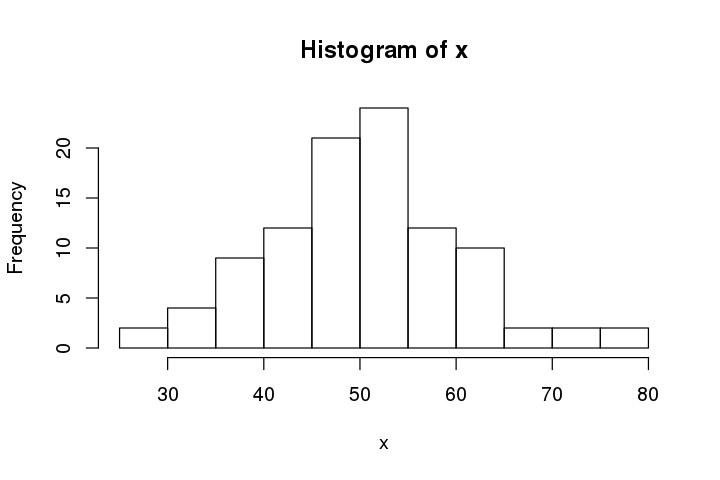

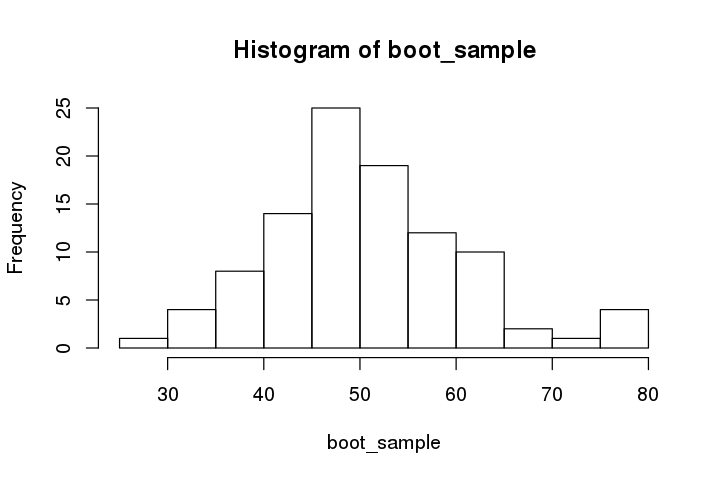

In [205]:
hist(x)
hist(boot_sample)

You should notice that the histograms look very similar, but they are not identical. If you re-run the cells above, the reasmple will change.

### 2. How do we get the `mean` of the resample?
This is actually really easy. Take a guess and try it in the next cell.

In [206]:
mean(boot_sample)

[1] 50.61544

Hopefully you guessed right, if not:

In [ ]:
mean(boot_sample)

Note that if we only wanted the mean of a given resample, we could skip the step of putting it into a variable (the `boot_sample` above) and just do this:

In [208]:
mean(sample(x, size = 100, replace = TRUE))

[1] 49.78372

Re-run the previous cell and notice that the value of the mean changes each time you run it.

### 3. How do we repeat this process?
This is where loops come into it. We need to do lots of resamples, compute the mean of each one, and store this mean in a variable. We already know from the examples above how to resample and how to get the mean of each resample. We will use a `for` loop to repeat this. So all we need to do now is to figure out how to collect the means into a variable.

In [ ]:
# Write a for-loop that computes the bootstrap mean 10 times --
#       that is, (1) get a random sample from x, (2) get the mean
#       of x, (3) store this in a variable m, and (4) print or
#       cat this to the screen
#
# Hint: don't worry about storing the results just yet, just
#       compute them. Note that if you do not use print or cat
#       you will not see ANY output from your loop!
#
# Hint: Remember that i in 1:10 will make the loop run 10 times



Hopefully you remember enough from the other units in this workshop to write a basic `for` loop here. If not, my answer is below, but try it a couple of times first. You can go back to previous notebooks for help. 

In this first pass, we are just repeating the process of running the function:
```R
m <- mean(sample(x, size = 100, replace = TRUE))
```
and hopefully "catting" it to the screen. We are not really doing anything with the value of `m` except seeing it. What we need to do is to store `m`, from each pass of the loop, into a new variable. This new variable needs to be a variable that can store as many values as times you run through the loop.

The easiest type of variable to store a list of numbers is an R vector, and we can create a new, empty, vector with the `vector` command:

In [209]:
vector(10, mode = "numeric")

[1] 0 0 0 0 0 0 0 0 0 0

The `mode = 'numeric'` part just tells R that the vector is to be used to store numbers.

Obviously we can give this a name, and when we do we can store numbers in the various locations by using basic indexing:

In [210]:
all_the_means <- vector(10, mode="numeric")
cat(all_the_means, "\n\n")

all_the_means[1] <- 1
all_the_means[3] <- 3
all_the_means[9] <- 9
cat(all_the_means, "\n")

0 0 0 0 0 0 0 0 0 0 

1 0 3 0 0 0 0 0 9 0 


Hopefully you see the idea coming here:

1. Create an empty vector with as many spaces as _times through the loop_ (N; in the example N = 10)
1. Have the loop variable (`i` usually) go from 1:N (here, 1:10)
1. **Use the `i` as an index variable and tell R to stick each newly computed `mean` (we called it `m` above) into the vector at location `i`: `all_the_means[i] <- m`** (This is the real "trick" here!)

When the loop is complete, `all_the_means` will contain a list of N means, and that is the bootstrap distribution of the means.

Before looking below for my answers, try building it yourself!

In [ ]:
# Allocate a vector to hold the values of the mean



In [ ]:
# Copy your loop from above here and modify the code to store m in
# the variable you just created



In [ ]:
# If you were successful, you can try printing the values from your
# vector of means, or making a histogram to see what they look like



Here are my answers. Note that your code might look different as there are some choices you can make about exactly how to do this.

In [211]:
# Here is my solution to the first problem of just printing the means

for(i in 1:10){
    m <- mean(sample(x, size = 100, replace = TRUE))
    cat(m, "\n")
}

50.25583 
50.91266 
49.23648 
50.27184 
50.5521 
49.83601 
51.27051 
50.48006 
48.60598 
50.46888 


In [212]:
# Here is my solution to the complete problem: Note in comparing this to the above code where the cat statement goes.

all_the_means <- vector(10, mode = "numeric")

for(i in 1:10){
    m <- mean(sample(x, size = 100, replace = TRUE))
    all_the_means[i] <- m
}

cat(all_the_means, sep="\n")

51.51388
49.82872
50.66191
48.64207
51.46215
49.02355
49.49425
49.93768
49.95424
51.07451


For bootstrapping to work, you need to do it a lot of times, not just 10. We can  modify the code to let us set `N` in one place and make that change all of the other references to it. To do this, we just replace the `10`'s in the code above with `N`, and add a line: `N <- something` to the top of the cell.

We will set `N` to be something large. In practical work, the minimum is usually about 200, and common values for `N` are 1000, 2000, 5000, or 10000. Usually going much larger is a waste of computing power, and going any lower gives bad estimates.

In [ ]:
# Modify the code above to use N in place of 10
#
# Hint: When you run this cell, you shoud see output similar to
#       above (but not identical!)
# Hint: To make your life easier below, you should name the collection
#       of means "all_the_means" as we use that name below

N <- 1000  # This should run relatively quickly on DICE

# Put your code here!


Make sure to run the cell above. We will need it below. In the code below I have assumed that you named the collection of means `all_the_means`. If you used another name, just change the variables below to match.

**Note**: I do not provide an exact solution to this exercise here, but you can see my solution below in the discussion of wrapping this up inside of a function.

### 4. How do we get the percentile limits?
R has a variety of ways to get the percentile limits of a data set. We can use these same functions on the bootstrapped means we just made. In essence, bootstrapping turns a problem of statistical theory into a data problem, except that the "data" is the bootstrapped statistic (in this case the collection of means). We just treat this as a sample and do what comes naturally.

To get the 95% limits, we need to pick out the 2.5% and 97.5% points in the ordered list of data. We can do this manually or by using the `quantile` function:

In [ ]:
# Automatically
quantile(all_the_means, probs = c(0.025, 0.975))

# Manually
s_all_means <- sort(all_the_means) # Sort from small to large

s_all_means[25]    # This is the 2.5% point of 1000 (0.025*1000)
s_all_means[975]   # 0.975*1000

Note that the numbers above are not quite the same, there is a lot of argumentation in statistics over the exact definitions of the quartiles and all of it amounts to very little. Notice that the numbers should be fairly close, within the first decimal place or so at least.

So, what did we do? We wanted to know the percentile limits for a 95% confidence interval for these data. Above we computed this assuming a normal distribution for the data. Here we did not assume this. But the results are comparable, as they should be for this data.

In [214]:
quantile(all_the_means, probs = c(0.025, 0.975))  # Simple Bootstrap

t.test(x)$conf.int   # Normal Theory (t)

2.5%    97.5% 
48.22495 52.14932

[1] 48.16649 52.16109
attr(,"conf.level")
[1] 0.95

The idea of bootstrapping is that this dropping of parametric assumptions for computing power is useful for a variety of purposes, for instance when:
+ The data is not specifically normal
+ The statistic of interest does not have a simple formula or procedure for constructing a confidence interval (like the median)

## A Simple Bootstrap Function
Let's see if we can make this easier to use. Here is my code for doing the bootstrap mean `N` (1000) times:

In [213]:
N <- 1000

all_the_means <- vector(N, mode = "numeric")

for(i in 1:N){
    m <- mean(sample(x, size = 100, replace = TRUE))
    all_the_means[i] <- m
}

quantile(all_the_means, probs = c(0.025, 0.975)) 

2.5%    97.5% 
48.22495 52.14932

It would be nice if we could wrap this up as a function that allowed me to:
+ Run the function on an arbitrary data set
+ Run the function on any value of `N`

This is relatively easy to do by letting the data set and N be variables for the function: 

In [215]:
boot_mean_95 <- function(x, N){
    all_the_means <- vector(N, mode = "numeric")
    for(i in 1:N){
        m <- mean(sample(x, size = 100, replace = TRUE))
        all_the_means[i] <- m
    }
    return(quantile(all_the_means, probs = c(0.025, 0.975)))
}

In [216]:
set.seed(3000)

boot_mean_95(x, 1000)
boot_mean_95(x, 200)
boot_mean_95(c(1,2,3), 200)

2.5%    97.5% 
48.33261 52.17251

2.5%    97.5% 
48.38977 51.97647

2.5%   97.5% 
1.85000 2.15025

Let's think about that last one. Instead of `x` I fed the function a list of 3 numbers, `c(1,2,3)`, so it computed things based on resamples from that data. What size were the resamples? Is that right?

Well we manually set the sample size to 100, which was the size of `x`. But we wanted the `size` parameter in `sample` to be equal to the size of the data set, which can change now. This is a problem.

How can we fix that? (Hint: ?length)

In [ ]:
# Copy the function boot_mean_95 here and fix the sample size problem
# using length
#
# Hint: It really is easy, just swap the wrong number for whatever
#       length tells you



In [ ]:
# Test

set.seed(1010)  # Set to known value for testing

boot_mean_95(c(1,2,3), 1000) # Should be 1 and 3 if right!

In [ ]:
# Write a new function to compute the 95% CI for the **median**
#
# Hint: This is easy, remember you can copy and paste
# Hint: The median is computed in R by the median function
# Hint: Call the function boot_median_95



In [ ]:
# Test for boot_median_95

set.seed(1000)
boot_median_95(x, 1000)  # Should be about 48.1391 and 52.1315

A slightly more advanced exercise is to let the user select the percentage for the CI. The more challenging way to do this is to take in a confidence level (like 0.95 for 95%) and determine the corresponding bounds. The function call would look like this:

```R
boot_median <- function(x, N, conf){
    your code
}
```
An easier way would be to simply accept the upper and lower bound, letting each be a variable in the function call:

```R
boot_median <- function(x, N, lwr, upr){
    your code
}
```
If you would like to try the harder way, the lower bound would be equal to $\mathrm{lwr} = \frac{1 - \mathrm{conf}}{2}$, and the upper bound would be $\mathrm{upr} = \frac{1 + \mathrm{conf}}{2}$. 

Note: The `quantile` function is helping us here a lot! If you were picking out these percentage points manually you would need to either (1) convert these to the nearest whole numbers or (2) take some averages of points as the two equations for `lwr` and `upr` above rarely give whole number values. But the `quantile` function is happy to accept any sort of decimal value for the quantiles to compute.

Try it:

In [ ]:
# Write a function to compute arbitrary median CIs here
#
# Pick either way of setting arbitrary limits. 



One of the nice features of R is that it allows named parameters in function calls to have **default** values set **in the function definition**. So, instead of defining our function as:

```R
boot_median <- function(x, N, conf){
    your code
}
```
We can define it with a default setting of 0.95 as that is common:
```R
boot_median <- function(x, N, conf = 0.95){
    your code
}
```
When R sees code like this, it uses the default value (here, `0.95`) when `conf` is left **unset** by the person using the function. But if the person uses the function and sets a different value, that gets used instead of the `0.95`.

In [ ]:
# Here is a version of the mean function above that allows the confidence
# interval to be set. This should look very siumilar to your (similar)
# function for the medians.

boot_mean <- function(x, N, conf = 0.95){
    all_the_means <- vector(N, mode = "numeric")
    for(i in 1:N){
        m <- mean(sample(x, size = length(x), replace = TRUE))
        all_the_means[i] <- m
    }
    lwr <- (1 - conf)/2
    upr <- (1 + conf)/2
    return(quantile(all_the_means, probs = c(lwr, upr)))
}

In [ ]:
# All of these should be the same as when tested with boot_mean_95
# above

set.seed(3000)

boot_mean(x, 1000)
boot_mean(x, 200)
boot_mean(c(1,2,3), 200)

In [ ]:
1.99/2
(1-.99)/2

In [ ]:
quantile(all_the_means, probs = c(0.025119, 0.9752345))

***
Version 1.0  
2018.07.11

To contact the author, email [mturner46@gsu.edu](mailto:mturner46@gsu.edu). Please contact me with recommendations for improvement or if you find any errors. This work may be adapted for any non-commercial purpose within the bounds of the license.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.